## Avaliação II: Modelagem e Mineração de Dados
## TalkingData Mobile User Demographics (Kaggle competition)

### Bruno Cuconato e Laura Sant'Anna
Team outliers, final rank: Top 41% (677º)

In [5]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import KFold
from sklearn.metrics import log_loss

diretórios:

In [6]:
datadir = '/tmp/kaggle/'
gatrain = pd.read_csv(os.path.join(datadir,'gender_age_train.csv'),
                      index_col='device_id')
gatest = pd.read_csv(os.path.join(datadir,'gender_age_test.csv'),
                     index_col = 'device_id')
phone = pd.read_csv(os.path.join(datadir,'phone_brand_device_model.csv'))
# Get rid of duplicate device ids in phone:
phone = phone.drop_duplicates('device_id',keep='first').set_index('device_id')

__Manipulação geral dos dados com base no usuário do Kaggle _dvasyukova_.__

____

#### __#1 attempt:__

atribui probabilidade geral da classe pra todos.

classificando labels das classes pra calcular logless usando validação cruzada:

In [7]:
letarget = LabelEncoder().fit(gatrain.group.values)
y = letarget.transform(gatrain.group.values)
nclasses = len(letarget.classes_)

In [8]:
kf = KFold(gatrain.shape[0], n_folds=10, shuffle=True, random_state=0)
preb_prod = np.zeros((gatrain.shape[0],nclasses))
for itrain, itest in kf:
    train = gatrain.iloc[itrain,:]
    test = gatrain.iloc[itest,:]
    ytrain, ytest = y[itrain], y[itest]
    prob = train.groupby('group').size()/train.shape[0]
    preb_prod[itest,:] = prob.values
print(log_loss(y, preb_prod))

2.42805122275


__#2 attempt__:

tentar identificar grupo usando marca+modelo do aparalho e apps através de Regressão Logística.

créditos a /u/dunedweller.


In [9]:
# for future reference, to know which id is from which sample.
gatrain['trainrow'] = np.arange(gatrain.shape[0])
gatest['testrow'] = np.arange(gatest.shape[0])

In [10]:
brandencoder = LabelEncoder().fit(phone.phone_brand)
phone['brand'] = brandencoder.transform(phone['phone_brand'])
gatrain['brand'] = phone['brand']
gatest['brand'] = phone['brand']
Xtr_brand = csr_matrix((np.ones(gatrain.shape[0]), 
                       (gatrain.trainrow, gatrain.brand)))
Xte_brand = csr_matrix((np.ones(gatest.shape[0]), 
                       (gatest.testrow, gatest.brand)))
print('Brand features: train shape {}, test shape {}'.format(Xtr_brand.shape, Xte_brand.shape))

Brand features: train shape (74645, 131), test shape (112071, 131)


In [11]:
m = phone.phone_brand.str.cat(phone.device_model)
modelencoder = LabelEncoder().fit(m)
phone['model'] = modelencoder.transform(m)
gatrain['model'] = phone['model']
gatest['model'] = phone['model']
Xtr_model = csr_matrix((np.ones(gatrain.shape[0]), 
                       (gatrain.trainrow, gatrain.model)))
Xte_model = csr_matrix((np.ones(gatest.shape[0]), 
                       (gatest.testrow, gatest.model)))
print('Model features: train shape {}, test shape {}'.format(Xtr_model.shape, Xte_model.shape))

Model features: train shape (74645, 1667), test shape (112071, 1667)


In [12]:
print(modelencoder.classes_)
print(modelencoder.transform(m))

['E人E本T9' 'E派T7' 'E派U5482' ..., '鲜米s800' '黑米A1' '黑米A5']
[858 843 371 ..., 860 847 220]


In [13]:
gatrain.head(2)

,gender,age,group,trainrow,brand,model
device_id,,,,,,
-8076087639492063270,M,35,M32-38,0,51,843
-2897161552818060146,M,35,M32-38,1,51,843


In [14]:
events = pd.read_csv(os.path.join(datadir,'events.csv'),
                     parse_dates=['timestamp'], index_col='event_id')
appevents = pd.read_csv(os.path.join(datadir,'app_events.csv'), 
                        usecols=['event_id','app_id','is_active'],
                        dtype={'is_active':bool})
applabels = pd.read_csv(os.path.join(datadir,'app_labels.csv'))

In [15]:
appevents.head(2)

,event_id,app_id,is_active
0,2,5927333115845830913,True
1,2,-5720078949152207372,False


In [16]:
appencoder = LabelEncoder().fit(appevents.app_id)
appevents['app'] = appencoder.transform(appevents.app_id)
napps = len(appencoder.classes_)

#appevents.is_active = appevents.is_active.replace(to_replace=[True, False], value= [1, 11])

#appevents['stapp'] = appevents.app * appevents.is_active
appevents.head(2)


,event_id,app_id,is_active,app
0,2,5927333115845830913,True,15408
1,2,-5720078949152207372,False,3384


In [17]:
"""stappencoder = LabelEncoder().fit(appevents.stapp)
appevents['estapp'] = stappencoder.transform(appevents.stapp)
nstapps = len(stappencoder.classes_)"""

deviceapps = (appevents.merge(events[['device_id']], how='left',left_on='event_id',right_index=True)
                       .groupby(['device_id','app'])['app'].agg(['size'])
                       .merge(gatrain[['trainrow']], how='left', left_index=True, right_index=True)
                       .merge(gatest[['testrow']], how='left', left_index=True, right_index=True)
                       .reset_index())
deviceapps.head(2)

,device_id,app,size,trainrow,testrow
0,-9222956879900151005,548,18,21594.0,NaN
1,-9222956879900151005,1096,18,21594.0,NaN


In [18]:
#print(deviceapps['sizeapp'].unique().shape[0], deviceapps.shape[0], deviceapps.app.unique().shape[0])

In [19]:
deviceapps.head(2)

,device_id,app,size,trainrow,testrow
0,-9222956879900151005,548,18,21594.0,NaN
1,-9222956879900151005,1096,18,21594.0,NaN


In [20]:
deviceapps['sizeapp'] = deviceapps.app * deviceapps.size
print(deviceapps['sizeapp'].unique().shape[0])
deviceapps.head(2)


19237


,device_id,app,size,trainrow,testrow,sizeapp
0,-9222956879900151005,548,18,21594.0,NaN,6491128500
1,-9222956879900151005,1096,18,21594.0,NaN,12982257000


In [21]:
saencoder = LabelEncoder().fit(deviceapps.sizeapp)
deviceapps['esizeapp'] = saencoder.transform(deviceapps.sizeapp)
nsaapps = len(saencoder.classes_)

In [22]:
gatrain.head(2)

,gender,age,group,trainrow,brand,model
device_id,,,,,,
-8076087639492063270,M,35,M32-38,0,51,843
-2897161552818060146,M,35,M32-38,1,51,843


In [23]:
d = deviceapps.dropna(subset=['trainrow'])
Xtr_app = csr_matrix((np.ones(d.shape[0]), (d.trainrow, d.app)), 
                      shape=(gatrain.shape[0],napps))
d = deviceapps.dropna(subset=['testrow'])
Xte_app = csr_matrix((np.ones(d.shape[0]), (d.testrow, d.app)), 
                      shape=(gatest.shape[0],napps))
print('Apps data: train shape {}, test shape {}'.format(Xtr_app.shape, Xte_app.shape))

Apps data: train shape (74645, 19237), test shape (112071, 19237)


In [24]:
d = deviceapps.dropna(subset=['trainrow'])
Xtr_sapp = csr_matrix((np.ones(d.shape[0]), (d.trainrow, d.esizeapp)), 
                      shape=(gatrain.shape[0],nsaapps))
d = deviceapps.dropna(subset=['testrow'])
Xte_sapp = csr_matrix((np.ones(d.shape[0]), (d.testrow, d.esizeapp)), 
                      shape=(gatest.shape[0], nsaapps))
print('Apps data: train shape {}, test shape {}'.format(Xtr_sapp.shape, Xte_sapp.shape))

Apps data: train shape (74645, 19237), test shape (112071, 19237)


In [25]:
applabels = applabels.loc[applabels.app_id.isin(appevents.app_id.unique())]
applabels['app'] = appencoder.transform(applabels.app_id)
labelencoder = LabelEncoder().fit(applabels.label_id)
applabels['label'] = labelencoder.transform(applabels.label_id)
nlabels = len(labelencoder.classes_)

In [26]:
devicelabels = (deviceapps[['device_id','app']]
                .merge(applabels[['app','label']])
                .groupby(['device_id','label'])['app'].agg(['size'])
                .merge(gatrain[['trainrow']], how='left', left_index=True, right_index=True)
                .merge(gatest[['testrow']], how='left', left_index=True, right_index=True)
                .reset_index())
devicelabels.head(2)

,device_id,label,size,trainrow,testrow
0,-9222956879900151005,117,1,21594.0,NaN
1,-9222956879900151005,120,1,21594.0,NaN


In [27]:
d = devicelabels.dropna(subset=['trainrow'])
Xtr_label = csr_matrix((np.ones(d.shape[0]), (d.trainrow, d.label)), 
                      shape=(gatrain.shape[0],nlabels))
d = devicelabels.dropna(subset=['testrow'])
Xte_label = csr_matrix((np.ones(d.shape[0]), (d.testrow, d.label)), 
                      shape=(gatest.shape[0],nlabels))
print('Labels data: train shape {}, test shape {}'.format(Xtr_label.shape, Xte_label.shape))

Labels data: train shape (74645, 492), test shape (112071, 492)


In [28]:
Xtrain = hstack((Xtr_brand, Xtr_model, Xtr_app, Xtr_label, Xtr_sapp), format='csr')
Xtest =  hstack((Xte_brand, Xte_model, Xte_app, Xte_label, Xte_sapp), format='csr')
Xtrain_bm = hstack((Xtr_brand, Xtr_model), format='csr')
Xtest_bm =  hstack((Xte_brand, Xte_model), format='csr')
print('All features: train shape {}, test shape {}'.format(Xtrain.shape, Xtest.shape))

All features: train shape (74645, 40764), test shape (112071, 40764)


In [29]:
targetencoder = LabelEncoder().fit(gatrain.group)
y = targetencoder.transform(gatrain.group)
nclasses = len(targetencoder.classes_)

In [30]:
def score(clf, random_state = 0): # 3 is best
    kf = StratifiedKFold(y, n_folds=5, shuffle=True, random_state=random_state)
    pred_log = np.zeros((y.shape[0],nclasses))
    for itrain, itest in kf:
        Xtr, Xte = Xtrain[itrain, :], Xtrain[itest, :]
        ytr, yte = y[itrain], y[itest]
        clf.fit(Xtr, ytr)
        pred_log[itest,:] = clf.predict_proba(Xte)
        # Downsize to one fold only for kernels
        return log_loss(yte, pred_log[itest, :])
        print("{:.5f}".format(log_loss(yte, pred[itest,:])), end=' ')
    print('')
    return log_loss(y, pred_log)

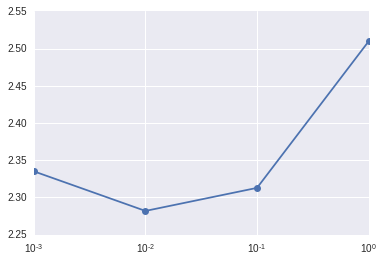

In [31]:
Cs = np.logspace(-3,0,4)
res = []
for C in Cs:
    res.append(score(LogisticRegression(C = C)))
plt.semilogx(Cs, res,'-o'); 

In [33]:
clf = LogisticRegression(C=0.02, multi_class='multinomial', solver='lbfgs')
clf.fit(Xtrain, y)
a = clf.predict_proba(Xtest)
pred_mlog = pd.DataFrame(a, index = gatest.index, columns=targetencoder.classes_)
a

array([[ 0.00092369,  0.00495377,  0.01257135, ...,  0.12157771,
         0.28074373,  0.39453305],
       [ 0.00864131,  0.01231834,  0.0286233 , ...,  0.07064807,
         0.25493801,  0.19236822],
       [ 0.02028392,  0.03483686,  0.03347828, ...,  0.09898323,
         0.1860645 ,  0.12665779],
       ..., 
       [ 0.06804535,  0.0506414 ,  0.03746396, ...,  0.12026859,
         0.10561777,  0.09226824],
       [ 0.06804535,  0.0506414 ,  0.03746396, ...,  0.12026859,
         0.10561777,  0.09226824],
       [ 0.06164854,  0.066917  ,  0.04918315, ...,  0.08803715,
         0.09358015,  0.07536871]])

In [32]:
score(LogisticRegression(C=0.02))

2.2808753886087869

### submission #3

base probabilidade de classes; pra quem tem eventos, regressão logística de apps, modelos, e marcas

In [34]:
pred_p = gatrain.groupby('group').size()/gatrain.shape[0]
pred_p = pred_p.values
pred_prob = pd.DataFrame([pred_p], index = gatest.index, columns = targetencoder.classes_)
pred_prob.head(2)

,F23-,F24-26,F27-28,F29-32,F33-42,F43+,M22-,M23-26,M27-28,M29-31,M32-38,M39+
device_id,,,,,,,,,,,,
1002079943728939269,0.067654,0.056132,0.041771,0.062,0.074499,0.056186,0.100315,0.128676,0.072945,0.097917,0.126948,0.114957
-1547860181818787117,0.067654,0.056132,0.041771,0.062,0.074499,0.056186,0.100315,0.128676,0.072945,0.097917,0.126948,0.114957


In [35]:
idevents = events['device_id'].unique().tolist()
idtest = gatest.index.values
idtest.shape

(112071,)

In [36]:
idsect = set(idevents).intersection(idtest)
len(idsect)

35194

In [37]:
pred3 = pred_prob.copy()
for i in idsect:
    pred3.ix[i] = pred_mlog.ix[i]

In [38]:
pred3.to_csv('sub3.csv.gzip', index = True, compression = 'gzip')

In [39]:
pred_f = 0.5*pred_mlog + 0.5*pred_prob
pred_f.head(2)

,F23-,F24-26,F27-28,F29-32,F33-42,F43+,M22-,M23-26,M27-28,M29-31,M32-38,M39+
device_id,,,,,,,,,,,,
1002079943728939269,0.034289,0.030543,0.027171,0.036027,0.051833,0.050056,0.055453,0.078944,0.067345,0.109747,0.203846,0.254745
-1547860181818787117,0.038147,0.034225,0.035197,0.059164,0.070467,0.100320,0.052446,0.111965,0.069180,0.084282,0.190943,0.153663


In [40]:
pred_f.to_csv('sub2.csv', index=True, compression = 'gzip')

### submission #4

regressão logística sobre modelo+marca e marca como base;  pra quem tem eventos, substitui por regressão logística de modelo+marca, marca, e apps

resultado: 2.26455 - melhor submissão, chegamos ao primeiro quartil no meio da competição, mas não conseguimos melhorar.

In [41]:
clf = LogisticRegression(C=0.02, multi_class='multinomial', solver='lbfgs')
clf.fit(Xtrain_bm, y)
a = clf.predict_proba(Xtest_bm)
pred_bm = pd.DataFrame(a, index = gatest.index, columns=targetencoder.classes_)

In [42]:
#já rodado lá em cima
idevents = events['device_id'].unique().tolist()
idtest = gatest.index.values
idtest.shape

(112071,)

In [43]:
idsect = set(idevents).intersection(idtest)
len(idsect)

35194

In [44]:
pred4 = pred_bm.copy()
for i in idsect:
    pred4.ix[i] = pred_mlog.ix[i]

In [45]:
pred4.to_csv('sub4.csv.gz', index = True, compression = 'gzip')

### submission #5

incluindo features de tempo dos eventos

resultado: score péssimo.

In [46]:
events['timestamp'] = pd.to_datetime(events['timestamp'], format = '%Y-%m-%d %H:%M:%S')
events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3252950 entries, 1 to 3252950
Data columns (total 4 columns):
device_id    int64
timestamp    datetime64[ns]
longitude    float64
latitude     float64
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 124.1 MB


In [47]:
idevents = events['device_id'].unique().tolist()

In [48]:
events.head()

,device_id,timestamp,longitude,latitude
event_id,,,,
1,29182687948017175,2016-05-01 00:55:25,121.38,31.24
2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97
3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70
4,-6815121365017318426,2016-05-01 00:06:40,104.27,23.28
5,-5373797595892518570,2016-05-01 00:07:18,115.88,28.66


In [49]:
timef = pd.DataFrame(index = idevents, columns = ['span', 'nr_e', 'freq'])

In [50]:
for i in idevents:
    max_ts = events[events['device_id'] == i]['timestamp'].max()
    min_ts = events[events['device_id'] == i]['timestamp'].min()
    timef.ix[i].iloc[0] = (max_ts - min_ts).days #in weeks, gotta think about other categorical variables.
    timef.ix[i].iloc[1] = events[events['device_id'] == i]['timestamp'].shape[0]

In [53]:
# salvando o arquivo pois a computação é intensiva e não precisa de ser repetida
timef.to_csv('/tmp/outliers/timef.csv.gz', index = True, compression = 'gzip')

#timef = pd.read_csv('/tmp/outliers/timef.csv.gz', index = True, compression = 'gzip')

In [54]:
spannotzero = timef['span']!=0
timef.loc[spannotzero, 'freq'] = timef.loc[spannotzero, 'nr_e']/timef.loc[spannotzero, 'span']
timef['freq'] = timef['freq'].fillna(9999).round(0)
timef.head()
timef.index.names = ['device_id']

In [55]:
timef.head()

,span,nr_e,freq
device_id,,,
29182687948017175,6,256,43.0
-6401643145415154744,4,73,18.0
-4833982096941402721,6,248,41.0
-6815121365017318426,0,47,9999.0
-5373797595892518570,6,525,88.0


In [56]:
# criando categorias com base nos percentis
def pct_rank_qcut(series, n):
    edges = pd.Series([float(i) / n for i in range(n + 1)])
    f = lambda x: (edges >= x).argmax()
    return series.rank(pct=1).apply(f)

timef['cfreq'] = pct_rank_qcut(timef.freq, 10)

In [57]:
#timef['cnre'] = pd.qcut(timef['nr_e'], 9, labels = None, retbins=False, precision=3)
#timef['cnre']

In [58]:
# encoding number of events (not sure if needed, but anyway)

nreencoder = LabelEncoder().fit(timef.nr_e)
timef['nr_e-e'] = nreencoder.transform(timef.nr_e)
nnr_e = len(nreencoder.classes_)

# encoding number of events per day (freq)

freqencoder = LabelEncoder().fit(timef.cfreq)
timef['freq-e'] = freqencoder.transform(timef.cfreq)
nfreq = len(freqencoder.classes_)

timef = (timef.merge(gatrain[['trainrow']], how='left', left_index=True, right_index=True)
                       .merge(gatest[['testrow']], how='left', left_index=True, right_index=True))
timef.head(2)

,span,nr_e,freq,cfreq,nr_e-e,freq-e,trainrow,testrow
device_id,,,,,,,,
29182687948017175,6,256,43.0,8,255,7,58469.0,NaN
-6401643145415154744,4,73,18.0,7,72,6,NaN,68691.0


In [59]:
d = timef.dropna(subset=['trainrow'])
Xtr_freq= csr_matrix((np.ones(d.shape[0]), (d.trainrow, d['freq-e'])), 
                      shape = (gatrain.shape[0], nfreq))
d = timef.dropna(subset=['testrow'])
Xte_freq = csr_matrix((np.ones(d.shape[0]), (d.testrow, d['freq-e'])), 
                      shape=(gatest.shape[0],nfreq))
print('Apps data: train shape {}, test shape {}'.format(Xtr_freq.shape, Xte_freq.shape))

Apps data: train shape (74645, 9), test shape (112071, 9)


In [60]:
d = timef.dropna(subset=['trainrow'])
Xtr_nre= csr_matrix((np.ones(d.shape[0]), (d.trainrow, d['nr_e-e'])), 
                      shape = (gatrain.shape[0], nnr_e))
d = timef.dropna(subset=['testrow'])
Xte_nre = csr_matrix((np.ones(d.shape[0]), (d.testrow, d['nr_e-e'])), 
                      shape=(gatest.shape[0], nnr_e))
print('Apps data: train shape {}, test shape {}'.format(Xtr_nre.shape, Xte_nre.shape))

Apps data: train shape (74645, 933), test shape (112071, 933)


In [61]:
Xtrain = hstack((Xtr_brand, Xtr_model, Xtr_app, Xtr_label, Xtr_nre, Xtr_freq), format='csr')
Xtest =  hstack((Xte_brand, Xte_model, Xte_app, Xte_label, Xte_nre, Xte_freq), format='csr')
print('All features: train shape {}, test shape {}'.format(Xtrain.shape, Xtest.shape))

All features: train shape (74645, 22469), test shape (112071, 22469)


In [62]:
score(LogisticRegression(C=0.02))

2.2800967625745105

### submission #6

tentando outras features de tempo.

In [63]:
events = pd.read_csv(os.path.join(datadir,'events.csv'),
                     parse_dates=['timestamp'], index_col='event_id')
appevents = pd.read_csv(os.path.join(datadir,'app_events.csv'), 
                        usecols=['event_id','app_id','is_active'],
                        dtype={'is_active':bool})
applabels = pd.read_csv(os.path.join(datadir,'app_labels.csv'))

In [64]:
events['hour'] = np.nan
events['minute'] = np.nan

events['timestamp'] = pd.to_datetime(events['timestamp'])

events['hour'] = events.timestamp.dt.hour
events['minute'] = events.timestamp.dt.minute
events['dweek'] = events.timestamp.dt.dayofweek

events = events.drop(events.columns[[1, 2, 3]], axis=1)
    
events.head(2)

,device_id,hour,minute,dweek
event_id,,,,
1,29182687948017175,0,55,6
2,-6401643145415154744,0,54,6


In [65]:
appencoder = LabelEncoder().fit(appevents.app_id)
appevents['app'] = appencoder.transform(appevents.app_id)
napps = len(appencoder.classes_)

appevents.head(2)


,event_id,app_id,is_active,app
0,2,5927333115845830913,True,15408
1,2,-5720078949152207372,False,3384


In [66]:
deviceapps = (appevents.merge(events[['device_id', 'dweek', 'hour', 'minute']], how='left',left_on='event_id',right_index=True)
                       .merge(gatrain[['trainrow']], how='left', left_index=True, right_index=True)
                       .merge(gatest[['testrow']], how='left', left_index=True, right_index=True))
deviceapps.head(2)

,event_id,app_id,is_active,app,device_id,dweek,hour,minute,trainrow,testrow
0,2,5927333115845830913,True,15408,-6401643145415154744,6,0,54,NaN,NaN
1,2,-5720078949152207372,False,3384,-6401643145415154744,6,0,54,NaN,NaN


In [67]:
d = deviceapps.dropna(subset=['trainrow'])
Xtr_app = csr_matrix((np.ones(d.shape[0]), (d.trainrow, d.app)), 
                      shape=(gatrain.shape[0],napps))
d = deviceapps.dropna(subset=['testrow'])
Xte_app = csr_matrix((np.ones(d.shape[0]), (d.testrow, d.app)), 
                      shape=(gatest.shape[0],napps))
print('Apps data: train shape {}, test shape {}'.format(Xtr_app.shape, Xte_app.shape))

Apps data: train shape (74645, 19237), test shape (112071, 19237)


In [68]:
ndays = len(deviceapps.dweek.unique())
d = deviceapps.dropna(subset=['trainrow'])
Xtr_day = csr_matrix((np.ones(d.shape[0]), (d.trainrow, d.dweek)), 
                      shape=(gatrain.shape[0], ndays))
d = deviceapps.dropna(subset=['testrow'])
Xte_day = csr_matrix((np.ones(d.shape[0]), (d.testrow, d.dweek)), 
                      shape=(gatest.shape[0], ndays))
print('Apps data: train shape {}, test shape {}'.format(Xtr_day.shape, Xte_day.shape))

Apps data: train shape (74645, 7), test shape (112071, 7)


In [69]:
nhour = len(deviceapps.hour.unique())
d = deviceapps.dropna(subset=['trainrow'])
Xtr_hour = csr_matrix((np.ones(d.shape[0]), (d.trainrow, d.hour)), 
                      shape=(gatrain.shape[0], nhour))
d = deviceapps.dropna(subset=['testrow'])
Xte_hour = csr_matrix((np.ones(d.shape[0]), (d.testrow, d.hour)), 
                      shape=(gatest.shape[0], nhour))
print('Apps data: train shape {}, test shape {}'.format(Xtr_hour.shape, Xte_hour.shape))

Apps data: train shape (74645, 24), test shape (112071, 24)


In [70]:
'''applabels = applabels.loc[applabels.app_id.isin(appevents.app_id.unique())]
applabels['app'] = appencoder.transform(applabels.app_id)
labelencoder = LabelEncoder().fit(applabels.label_id)
applabels['label'] = labelencoder.transform(applabels.label_id)
nlabels = len(labelencoder.classes_)'''

"applabels = applabels.loc[applabels.app_id.isin(appevents.app_id.unique())]\napplabels['app'] = appencoder.transform(applabels.app_id)\nlabelencoder = LabelEncoder().fit(applabels.label_id)\napplabels['label'] = labelencoder.transform(applabels.label_id)\nnlabels = len(labelencoder.classes_)"

In [71]:
'''devicelabels = (deviceapps[['device_id','app']]
                .merge(applabels[['app','label']])
                .groupby(['device_id','label'])['app'].agg(['size'])
                .merge(gatrain[['trainrow']], how='left', left_index=True, right_index=True)
                .merge(gatest[['testrow']], how='left', left_index=True, right_index=True)
                .reset_index())
devicelabels.head(2)'''

"devicelabels = (deviceapps[['device_id','app']]\n                .merge(applabels[['app','label']])\n                .groupby(['device_id','label'])['app'].agg(['size'])\n                .merge(gatrain[['trainrow']], how='left', left_index=True, right_index=True)\n                .merge(gatest[['testrow']], how='left', left_index=True, right_index=True)\n                .reset_index())\ndevicelabels.head(2)"

In [72]:
'''d = devicelabels.dropna(subset=['trainrow'])
Xtr_label = csr_matrix((np.ones(d.shape[0]), (d.trainrow, d.label)), 
                      shape=(gatrain.shape[0],nlabels))
d = devicelabels.dropna(subset=['testrow'])
Xte_label = csr_matrix((np.ones(d.shape[0]), (d.testrow, d.label)), 
                      shape=(gatest.shape[0],nlabels))
print('Labels data: train shape {}, test shape {}'.format(Xtr_label.shape, Xte_label.shape))'''

"d = devicelabels.dropna(subset=['trainrow'])\nXtr_label = csr_matrix((np.ones(d.shape[0]), (d.trainrow, d.label)), \n                      shape=(gatrain.shape[0],nlabels))\nd = devicelabels.dropna(subset=['testrow'])\nXte_label = csr_matrix((np.ones(d.shape[0]), (d.testrow, d.label)), \n                      shape=(gatest.shape[0],nlabels))\nprint('Labels data: train shape {}, test shape {}'.format(Xtr_label.shape, Xte_label.shape))"

In [73]:
Xtrain = hstack((Xtr_brand, Xtr_model, Xtr_app, Xtr_hour, Xtr_day), format='csr')
Xtest =  hstack((Xte_brand, Xte_model, Xte_app, Xte_day, Xte_hour), format='csr')
'''Xtrain_bm = hstack((Xtr_brand, Xtr_model), format='csr')
Xtest_bm =  hstack((Xte_brand, Xte_model), format='csr')
'''
print('All features: train shape {}, test shape {}'.format(Xtrain.shape, Xtest.shape))

All features: train shape (74645, 21066), test shape (112071, 21066)


In [74]:
targetencoder = LabelEncoder().fit(gatrain.group)
y = targetencoder.transform(gatrain.group)
nclasses = len(targetencoder.classes_)

In [75]:
def score(clf, random_state = 0): # 3 is best
    kf = StratifiedKFold(y, n_folds=5, shuffle=True, random_state=random_state)
    pred_log = np.zeros((y.shape[0],nclasses))
    for itrain, itest in kf:
        Xtr, Xte = Xtrain[itrain, :], Xtrain[itest, :]
        ytr, yte = y[itrain], y[itest]
        clf.fit(Xtr, ytr)
        pred_log[itest,:] = clf.predict_proba(Xte)
        # Downsize to one fold only for kernels
        return log_loss(yte, pred_log[itest, :])
        print("{:.5f}".format(log_loss(yte, pred[itest,:])), end=' ')
    print('')
    return log_loss(y, pred_log)

In [76]:
score(LogisticRegression(C=0.02))

2.3988133174331967

__submission #7__

RANDOM FOREST - tentando implementar os classificadores visto em aula

resultado: score péssimo, rejeitamos.

In [78]:
from sklearn.ensemble import RandomForestClassifier

score(RandomForestClassifier(n_estimators=1000, 
                                   criterion='gini', 
                                   max_depth=None, 
                                   min_samples_split=2, 
                                   min_samples_leaf=1, 
                                   min_weight_fraction_leaf=0.0, 
                                   max_features='auto', 
                                   max_leaf_nodes=None, 
                                   bootstrap=False, 
                                   oob_score=False, 
                                   n_jobs=4, 
                                   random_state=1, 
                                   verbose=0, 
                                   warm_start=True, 
                                   class_weight=None))

3.8056142411232643

__submission #8__

GRADIENT BOOST - tentando implementar os classificadores vistos em aula

resultado: nunca parou de rodar.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

score(GradientBoostingClassifier(loss='deviance',
                                        learning_rate=0.1,
                                        n_estimators=1000,
                                        subsample=1.0,
                                        min_samples_split=2,
                                        min_samples_leaf=1,
                                        min_weight_fraction_leaf=0.0,
                                        max_depth=3,
                                        init=None,
                                        random_state=0,
                                        max_features=None,
                                        verbose=0,
                                        max_leaf_nodes=None,
                                        warm_start=False,
                                        presort='auto'))